In [1]:
import os
os.chdir("../")

In [2]:
from attacker.ResNet34 import *
from attacker.query import *
from attacker.utils import set_seed
import torchvision

# REF: https://towardsdev.com/implement-resnet-with-pytorch-a9fb40a77448

In [3]:
set_seed(42)

Files already downloaded and verified
Files already downloaded and verified


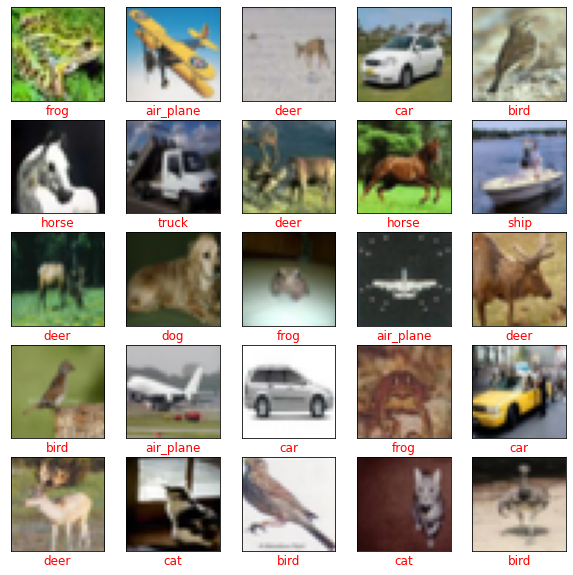

In [4]:
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(
    root='./cifar10', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=config['batch_size'], shuffle=True)

testset = torchvision.datasets.CIFAR10(
    root='./cifar10', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=config['batch_size'], shuffle=False)

class_names = ['air_plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# get some random training images
plt.figure(figsize=(10, 10))
counter = 0
for images, labels in trainloader:
    for i, img in enumerate(images):
        plt.subplot(5, 5, counter+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        img = img/2 + 0.5   # unmornalize
        # convert (C,H,W) to (H,W,C)
        img_show = np.transpose(img, (1, 2, 0))
        plt.imshow(img_show, cmap=plt.cm.binary)
        plt.xlabel(class_names[int(labels[i])], color='red', fontsize='large')
        counter += 1
        if counter == 25:
            break
    if counter == 25:
        break

plt.show()

# Query Victim Model

In [ ]:
queryloader = QueryVictimModel(victim, trainloader, config["query_size"], sampling='random')

In [6]:
queryloader = QueryVictim(None, trainloader, config["query_size"], sampling='random')

usage: ipykernel_launcher.py [-h] [--test_phase {0,1}] [--dev {0,1}]
                             [--logger {tensorboard,wandb}]
                             [--classifier CLASSIFIER] [--pretrained {0,1}]
                             [--precision {16,32}] [--batch_size BATCH_SIZE]
                             [--max_epochs MAX_EPOCHS]
                             [--num_workers NUM_WORKERS] [--gpu_id GPU_ID]
                             [--learning_rate LEARNING_RATE]
                             [--weight_decay WEIGHT_DECAY]
ipykernel_launcher.py: error: unrecognized arguments: -f /home/Aishu/.local/share/jupyter/runtime/kernel-801bffb6-b491-47dc-985f-0c36ea204f24.json


SystemExit: 2

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3532: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


# Train Attacker Model on queried data

In [ ]:
attacker = ResNet34(3, ResBlock, outputs=10)
attacker_loss = torch.nn.CrossEntropyLoss()

In [ ]:
attacker_result = Training(attacker, queryloader, testloader, (-1, 3, 32, 32), config["epochs"], optimizer=torch.optim.Adam(
    attacker.parameters(), lr=config["learning_rate"]), loss=attacker_loss)

In [ ]:
plots(attacker_result, 'ResNet34-Attacker')

In [ ]:
# Loop through all Types of queries
query_types = ['None', 'random', 'coreset', 'coreset_cross']
for type in query_types:
    # initialize model
    attacker = ResNet34(3, ResBlock, outputs=10)
    attacker_loss = torch.nn.CrossEntropyLoss()
    # query data
    queryloader= queryloader = QueryVictim(None, trainloader, config["query_size"], sampling=type)
    # train model
    attacker_result = Training(attacker, queryloader, testloader, (-1, 3, 32, 32), config["epochs"], optimizer=torch.optim.Adam(
    attacker.parameters(), lr=config["learning_rate"]), loss=attacker_loss)
    # save model inference
    torch.save(victim.state_dict(), f'Attacker-resnet34-{type}')
    # visualize results
    plots(attacker_result, f'Attacker-resnet34-{type}')


# Train a pseudo victim Model

In [ ]:
# create victim as resnet34
victim = ResNet34(3, ResBlock, outputs=10)
victim_loss = torch.nn.CrossEntropyLoss()

# train model
victim_result = Training(victim, trainloader, testloader, (-1, 3, 32, 32), config["epochs"], optimizer=torch.optim.Adam(
    victim.parameters(), lr=config["learning_rate"]), loss=victim_loss)

# save model inference
torch.save(victim.state_dict(), 'Victim_resnet34')

# visualization
plots(victim_result, 'Victim-resnet34')

# Load Victim from File

In [ ]:
victim = ResNet34(3, ResBlock, outputs=10)
victim.load_state_dict(torch.load('Victim_resnet34'))
victim.eval()